In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from torch import nn
import torch.nn.functional as F
from scipy.stats import linregress
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
device = 'cpu'

In [10]:
def moving_average(data, window_size=15):
    print("MA SHAPE:", data.shape)
    X_smooth = np.zeros(data.shape)
    for i,channel in enumerate(data):
        X_smooth[i] = np.convolve(channel, np.ones(window_size)/window_size, mode='same')
    return torch.from_numpy(X_smooth).to(torch.float32)
def warp_time(data, label, max_scale=1.5):
    data = data.numpy()

    L = data.shape[1]
    scale = np.random.uniform(1, max_scale)
    new_L = int(L * scale)
    orig_t = np.linspace(0, 1, L)
    new_t = np.linspace(0, 1, new_L)

    warped = np.zeros((data.shape[0], new_L))
    for i, channel in enumerate(data):
        warped[i] = np.interp(new_t, orig_t, channel)
    
    # label = torch.from_numpy(np.interp(new_t, orig_t, label)).to(torch.float32)
    # label = label * scale

    # randomly crop to original length
    if new_L > L:
        start_idx = np.random.randint(0, new_L - L)
        warped = warped[:, start_idx:start_idx + L]
        # label = label[start_idx:start_idx + L]
        # label = label - (start_idx / L)

    return torch.from_numpy(warped).to(torch.float32), label

def scale(data, low=0.6, high=1.4):
    return data*np.random.uniform(low, high)

def segment_y(y, t=40):
    end_rep_markers = torch.where(torch.diff(y) < 0)[0]
    y = torch.zeros_like(y)
    starts = (end_rep_markers - t).clamp(0)
    ends = (end_rep_markers + t).clamp(0, y.shape[0])
    for start,end in zip(starts, ends):
        y[start: end] = 1
    return y
class IMUDataset(Dataset):
    def __init__(self, df, winsize, stride, full_winsize, n_LSTM_windows, LSTM_stride, transform=None, aug=False, extra_pad=False):
        self.X = torch.from_numpy(df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values)
        self.y = torch.from_numpy(df['rir'].values).to(torch.float32)
        if transform is not None:
            self.X = transform(self.X)
        self.X = self.X.transpose(0, 1).to(torch.float32)
        self.winsize = winsize
        self.stride = stride
        self.full_winsize = full_winsize
        self.n_LSTM_windows = n_LSTM_windows
        self.LSTM_stride = LSTM_stride
        self.aug = aug


        self.len = (self.X.shape[1] - full_winsize) // stride + 1

        # pad to get at least one window
        if self.len <= 0:
            pad = full_winsize - self.X.shape[1]
            self.X = torch.cat([self.X, torch.zeros(self.X.shape[0], pad)], dim=1)
            self.y = torch.cat([self.y, torch.zeros(pad)])

        if extra_pad:
            # pad by winsize // 2 to get more windows
            pad = (winsize // 2) * stride
            self.X = torch.cat([self.X, torch.zeros(self.X.shape[0], pad)], dim=1)
            self.y = torch.cat([self.y, torch.zeros(pad)])
        
        self.len = (self.X.shape[1] - full_winsize) // stride + 1

    def __len__(self):
        return self.len
    def __getitem__(self, i):
        if i >= self.len:
            raise IndexError
        start = i * self.stride
        end = start + self.full_winsize

        X = self.X[:, start:end]
        y = self.y[start:end]

        X = moving_average(X)
        if self.aug:
            X,y = warp_time(X,y)
            X = scale(X)
        
        # window by LSTM stride
        X = X.unfold(1, self.winsize, self.LSTM_stride).permute(1,0,2)
        y = y.unfold(0, self.winsize, self.LSTM_stride)

        # FOR REGRESSION: y = y.mean() (single value)
        # y = y.mean()

        # FOR BINARY: 1 if y is last rep (< 0.5), 0 if not (single value)
        # y = torch.Tensor([1.0 if y.mean() < 0.5 else 0.0])
        y = (y.mean(dim=1) < 2.5).float().unsqueeze(1)

        # FOR SEGMENTATION: if y changes during window, y = 1 at that point. everywhere else is 0 (<winsize> values)
        # y = segment_y(y)

        # FOR SEGMENTATION REGRESSION: y = time when y changes (single value)
        # diff = torch.diff(y)
        # y = torch.diff(y).argmin().unsqueeze(0) / self.winsize if diff.min() < 0 else torch.Tensor([-1])
        
        return X, y

In [11]:
HZ = 100
in_channels = 6
df= pd.read_csv('./data.csv')
session_ids = df['session_id'].unique()
print(len(session_ids))
train_ids, val_ids = train_test_split(session_ids, test_size=0.2, random_state=42)
print(train_ids)
print(max(train_ids))
print(val_ids)
print(max(val_ids))
train_ids = np.array([train_id for train_id in train_ids if df[df.session_id == train_id].failure.sum()])
val_ids = np.array([val_id for val_id in val_ids if df[df.session_id == val_id].failure.sum()])

# df[['acc_x', 'acc_y', 'acc_z']] = (df[['acc_x', 'acc_y', 'acc_z']] / 2.0).clip(-1, 1)           # normalize accelerometer data from [-2g, 2g] to [-1, 1]
# df[['gyr_x', 'gyr_y', 'gyr_z']] = (df[['gyr_x', 'gyr_y', 'gyr_z']] / 250.0).clip(-1, 1)         # normalize gyroscope data from [-250dps, 250dps] to [-1, 1]

# winsize_t = 5 # seconds
# stride_t = 0.01 # seconds
# winsize = int(winsize_t * HZ)
# stride = int(stride_t * HZ)
winsize = 256
stride = 2

n_LSTM_windows = 32
LSTM_stride = 64
print(winsize, stride)

full_winsize = LSTM_stride * (n_LSTM_windows-1) + winsize
print(full_winsize)

train = df.loc[df['session_id'].isin(train_ids), ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
# norm = torch.from_numpy(train.mean(axis=0)), torch.from_numpy(train.std(axis=0))

# def transform(x):
    # return (x - norm[0]) / norm[1]
transform = None

train_dataset = ConcatDataset([IMUDataset(
    df[df['session_id'] == session_id], 
    winsize, stride,
    full_winsize, n_LSTM_windows, LSTM_stride,
    transform, aug=True, extra_pad=True
) for session_id in train_ids])
val_dataset = ConcatDataset([IMUDataset(
    df[df['session_id'] == session_id], 
    winsize, stride, 
    full_winsize, n_LSTM_windows, LSTM_stride,
    transform, aug=False, extra_pad=True
) for session_id in val_ids])

len(train_dataset), len(val_dataset)

74
[22 57 50 33 39 70 16 35 44 61  7 56 42 30 47 49 19 59 25 40 13 53  3 17
 38  8 58  6 36 67 54 46 72 15 27 41 26 48 24 62 66 11 32 69 64 37 29 43
 68  1 52 21  2 23 20 60 71 14 51]
72
[ 4 63 18  0 28 73 10 34 12 55 65 31  9 45  5]
73
256 2
2240


(44802, 11043)

In [12]:
def get_time_in_reps(preds, stride, winsize):
    print("Preds shape test:", preds.shape)
    # preds: N x T x C
    time_in_rep = []
    # consolidated = []
    end_reps = []
    for pred in preds: # each element in batch
        consolidatedi = []
        for i,predi in enumerate(pred): # each element in time
            upper = stride if i < len(pred) - 1 else len(predi)
            consolidatedi.append(predi[:upper])
        consolidatedi = torch.cat(consolidatedi, axis=0)
        consolidatedi = torch.from_numpy(np.convolve(consolidatedi, np.ones(100)/100, mode='same').round()).to(torch.float32)

        time_in_repi = torch.zeros_like(consolidatedi).to(torch.float32)
        end_repsi = []
        if consolidatedi.sum() > 0:
            diff = np.diff(consolidatedi)
            starts = np.where(diff > 0)[0]
            ends = np.where(diff < 0)[0]
            if len(starts) == 0 or len(ends) == 0:
                if len(starts) == 0:
                    # len(end) == 1 -> start is the beginning of session
                    starts = np.array([0])
                elif len(ends) == 0:
                    # len(start) == 1 -> end is the end of session
                    ends = np.array([len(pred[0])])
            else:
                if starts[0] > ends[0]:
                    # first end has no start -> first start is the beginning of session
                    starts = np.concatenate([[0], starts])
                if ends[-1] < starts[-1]:
                    # last start has no end -> last end is the end of session
                    ends = np.concatenate([ends, [len(pred[0])]])
            for start,end in zip(starts, ends):
                end_repsi.append((start + end) // 2)
            
            for i in range(1, len(end_repsi)):
                time_in_repi[end_repsi[i-1]:end_repsi[i]] = (end_repsi[i] - end_repsi[i-1]) / full_winsize
                # time_in_rep.append(end_repsi[i] - end_repsi[i-1])

        end_reps.append(end_repsi)
        # consolidated.append(consolidatedi)
        time_in_rep.append(time_in_repi)
    # preds = torch.stack(consolidated, axis=0)
    time_in_rep = torch.stack(time_in_rep, axis=0)

    print("END REPS:", end_reps)

    # rewindow
    time_in_rep = time_in_rep.unfold(1, winsize, stride)

    if preds.shape == torch.Size([1, 32, 256]):
        if not os.path.isfile('fullTIRComparison.txt'):
            np.savetxt('fullTIRComparison.txt', time_in_rep.squeeze(0).numpy())
            print("Saved file")        

    return time_in_rep

class ResBlock(nn.Module):
    # One layer of convolutional block with batchnorm, relu and dropout
    def __init__(
            self, in_channels, out_channels,
            kernel_size=3, stride=1, dropout=0.0,
        ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(
                in_channels, out_channels, 
                kernel_size=kernel_size, stride=stride, padding=kernel_size // 2,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.skip = nn.Conv1d(
            in_channels, out_channels, kernel_size=1, stride=stride
        ) if in_channels != out_channels or stride > 1 else nn.Identity()
    def forward(self, x):
        return self.block(x) + self.skip(x)
    
class DepthBlock(nn.Module):
    # "depth" number of ConvBlocks with downsample on the first block
    def __init__(
            self, depth, in_channels, out_channels,
            kernel_size=3, downsample_stride=2, 
            dropout=0.0
    ):
        super().__init__()
        self.blocks = nn.Sequential(*[
            ResBlock(
                in_channels=in_channels if i == 0 else out_channels, 
                out_channels=out_channels,
                kernel_size=kernel_size, 
                stride=downsample_stride if i == 0 else 1,
                dropout=dropout
            )
            for i in range(depth)
        ])
    def forward(self, x):
        return self.blocks(x)
 
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.width = config['width']
        self.depth = config['depth']
        self.stem_out_c = config['stem_out_c']
        self.stem_kernel = config['stem_kernel']
        self.dropout = config['dropout']

        if len(self.width) != len(self.depth):
            raise ValueError('Width and depth must have the same length')
        self.conv_out_channels = self.stem_out_c if len(self.width) == 0 else self.width[-1]

        self.encoder = nn.Sequential(
            # nn.Conv1d(in_channels, self.stem_out_c, kernel_size=self.stem_kernel, padding=self.stem_kernel // 2, stride=2),
            # nn.BatchNorm1d(self.stem_out_c),
            # nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            ResBlock(in_channels, self.stem_out_c, kernel_size=self.stem_kernel, stride=2),
            *[DepthBlock(
                depth=self.depth[i],
                in_channels=self.stem_out_c if i == 0 else self.width[i-1], 
                out_channels=self.width[i],
                dropout=self.dropout, 
            ) for i in range(len(self.width))]
        )
    def forward(self, x):
        return self.encoder(x)

class ConvNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.encoder = Encoder(config)
        self.ap = nn.AdaptiveAvgPool1d(1)
        # self.fc = nn.Linear(512, winsize // 2)
        self.fc = nn.Linear(self.encoder.conv_out_channels, winsize)
    def forward(self, x):
        emb = self.encoder(x)
        # x = self.conv(x)
        x = self.ap(emb).squeeze(-1)
        seg_logits = self.fc(x)
        # x = torch.repeat_interleave(x, 2, dim=1)
        return emb, seg_logits
    
    def freeze(self, stop_idx=None):
        if stop_idx is None:
            stop_idx = len(self.encoder.encoder)
        for block in self.encoder.encoder[:stop_idx]:
            for param in block.parameters():
                param.requires_grad = False
        for param in self.fc.parameters():
            param.requires_grad = False

class LSTMNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        in_channels = 6


        self.encoder = ConvNet(config)
        hidden_size = config['lstm_config']['hidden_size']
        # encoder_proj_channels = config['lstm_config']['encoder_proj_channels']
        skip_channels = config['lstm_config']['skip_channels']
        num_layers = config['lstm_config']['num_layers']
        dropout = config['lstm_config']['dropout']
        linear_hidden_size = config['lstm_config']['linear_hidden_size']

        # # Project encoder output to hidden size
        # self.conv_proj = nn.Conv1d(
        #     self.encoder.encoder.conv_out_channels, 
        #     encoder_proj_channels, 
        #     kernel_size=1
        # )

        # Convolution layer from input signal to skip_channels size
        self.conv_skip = nn.Sequential(
            nn.Conv1d(in_channels, skip_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(skip_channels),
            nn.ReLU(),
            # ResBlock(in_channels, skip_channels, kernel_size=7, stride=1),
        )
        self.ap = nn.AdaptiveAvgPool1d(1)

        # Project encoder, skip layer, and time_in_reps to lstm input size
        self.lstm_proj = nn.Linear(
            # encoder_proj_channels + skip_channels + winsize,
            self.encoder.encoder.conv_out_channels + skip_channels + winsize,
            hidden_size
        )

        # LSTM layer on projected encoder, skip layer, and time_in_reps
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout
        )

        # Linear layer to predict the output
        if linear_hidden_size == 0:
            self.fc = nn.Linear(hidden_size, 1)
        else:
            self.fc = nn.Sequential(
                nn.Linear(hidden_size, linear_hidden_size),
                nn.ReLU(),
                nn.Linear(linear_hidden_size, 1)
            )
    def forward(self, x):
        N, T, C, L = x.shape

        x = x.view(N*T, C, L)
        
        # Run encoder to get embeddings and segmentation logits
        x_seg, seg_logits = self.encoder(x)

        # x_seg = self.conv_proj(x_seg)
        x_seg = self.ap(x_seg).squeeze(-1)
        x_seg = x_seg.view(N, T, -1)

        # Project segmentation logits to seg_proj_size
        seg_logits = F.sigmoid(seg_logits).round()
        time_in_rep = get_time_in_reps(seg_logits.view(N, T, L).detach().cpu(), LSTM_stride, winsize).to(x.device)

        x_skip = self.conv_skip(x)
        x_skip = self.ap(x_skip).squeeze(-1)
        x_skip = x_skip.view(N, T, -1)

        x = torch.cat([x_seg, x_skip, time_in_rep], dim=2)
        x = self.lstm_proj(x)

        o, (h,c) = self.lstm(x)
        # x = self.fc(o[:, -1, :]) # predict for last time step
        x = self.fc(o)        # predict for all time steps
        return x
    
    def get_optimizer(self, lr, weight_decay=1e-4, betas=(0.9, 0.999)):
        # AdamW optimzer - apply weight decay to linear and conv weights
        # but not to biases and batchnorm layers
        params = self.named_parameters()
        decay_params = [p for n,p in params if p.dim() >= 2]
        no_decay_params = [p for n,p in params if p.dim() < 2]
        optimizer = torch.optim.AdamW([
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': no_decay_params, 'weight_decay': 0.0}
        ], betas=betas, lr=lr)
        return optimizer

class Loss(nn.Module):
    def __init__(self, device, pos_weight):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([pos_weight]).to(device))
        # self.loss = nn.BCEWithLogitsLoss()
        # self.loss = nn.MSELoss()
    def forward(self, y_pred, y_true):
        return self.loss(y_pred, y_true)
        # return self.loss(y_pred, y_true[:,-1])

In [13]:
weights, config = torch.load('./best_model-3binary-77.pth', map_location=torch.device('cpu'))
# weights, config = torch.load('../best_model-lstm-83t_32-timerep.pth')
# config = json.load(open('../logs/search256/34/config.json'))
# weights = torch.load('../logs/search256/34/best_model.pth')
model = LSTMNet(config).to(device)
model.load_state_dict(weights)
model.eval()
#evaluate(model, valloader, trainloader)

/var/folders/jy/pdjxhl6d6q58q0b7w0sk_g_80000gn/T/ipykernel_24905/637774803.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights, config = torch.load('./best_model-3bi

LSTMNet(
  (encoder): ConvNet(
    (encoder): Encoder(
      (encoder): Sequential(
        (0): ResBlock(
          (block): Sequential(
            (0): Conv1d(6, 256, kernel_size=(7,), stride=(2,), padding=(3,))
            (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Dropout(p=0.0, inplace=False)
          )
          (skip): Conv1d(6, 256, kernel_size=(1,), stride=(2,))
        )
        (1): DepthBlock(
          (blocks): Sequential(
            (0): ResBlock(
              (block): Sequential(
                (0): Conv1d(256, 256, kernel_size=(3,), stride=(2,), padding=(1,))
                (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU()
                (3): Dropout(p=0.11735231859672823, inplace=False)
              )
              (skip): Conv1d(256, 256, kernel_size=(1,), stride=(2,))
            )
          )
        )
        (

In [14]:
class IMUDatasetSimple(Dataset):
    def __init__(self, df, winsize=256, stride=64, transform=None, aug=False):
        self.X = torch.from_numpy(df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values)
        self.y = torch.from_numpy(df['rir'].values).to(torch.float32)
        if transform is not None:
            self.X = transform(self.X)
        self.X = self.X.transpose(0, 1).to(torch.float32)
        self.winsize = winsize
        self.stride = stride
        self.aug = aug

        self.len = (self.X.shape[1] - winsize) // stride + 1
        print("Len:", self.len)
        # pad to get at least one window
        if self.len <= 0:
            pad = winsize - self.X.shape[1]
            self.X = torch.cat([self.X, torch.zeros(self.X.shape[0], pad)], dim=1)
            self.y = torch.cat([self.y, torch.zeros(pad)])

        # pad by winsize // 2 to get more windows
        pad = (winsize // 2)
        self.X = torch.cat([self.X, torch.zeros(self.X.shape[0], pad)], dim=1)
        print("Shape at this point:", self.X.shape)
        self.y = torch.cat([self.y, torch.zeros(pad)])

        self.len = (self.X.shape[1] - winsize) // stride + 1
    def __len__(self):
        return self.len
    def __getitem__(self, i):
        if i >= self.len:
            raise IndexError
        start = i * self.stride
        print("Start:", start)
        end = start + self.winsize
        print("End:", end)
        y = self.y[start:end]#.mean()

        # FOR REGRESSION: y = y.mean() (single value)
        # y = y.mean()

        # FOR BINARY: 1 if y is last rep (< 0.5), 0 if not (single value)
        y = torch.Tensor([1.0 if y.mean() < 2.5 else 0.0])

        # FOR SEGMENTATION: if y changes during window, y = 1 at that point. everywhere else is 0 (<winsize> values)
        # y = segment_y(y)

        # FOR SEGMENTATION REGRESSION: y = time when y changes (single value)
        # diff = torch.diff(y)
        # y = torch.diff(y).argmin().unsqueeze(0) / self.winsize if diff.min() < 0 else torch.Tensor([-1])
        X = self.X[:, start:end]
        print(self.X.shape, X.shape)
        # X = moving_average(X)
        if self.aug:
            X,y = warp_time(X, y)
            X = scale(X)
        return X, y

In [15]:
def evaluate_real_time(session_id, interval=64):
    session = df[df['session_id'] == session_id]
    session_dataset = IMUDatasetSimple(session, winsize, interval, transform=None, aug=False)

    confs = []
    ys = []
    ypreds = []
    running_context = []
    popped = False
    with torch.no_grad():
        for X,y in session_dataset:
            X = X.unsqueeze(0).to(device)
            running_context.append(X.unsqueeze(0))
            if len(running_context) > n_LSTM_windows:
                # if not os.path.isfile('evaluate-real-time-comparison2.txt'):
                #     running_contextnew = running_context
                #     running_contextnew.pop(32)
                #     Xnew = torch.cat(running_contextnew, dim=1)
                #     np.savetxt('evaluate-real-time-comparison2.txt', Xnew.flatten().numpy())
                #     conf = model(Xnew).cpu()
                #     conf = F.sigmoid(conf[:,-1, 0])
                #     confs.append(conf)
                #     confs = torch.cat(confs).flatten()
                #     print("Corresponding CONFS:", confs)
                running_context.pop(0)
                popped = True
            X = torch.cat(running_context, dim=1)
            print("Length:", len(running_context))
            if popped:
                print("SHAPE!!!!!:", X.shape)
            print("X TYPE", X.dtype)
            print(X)
            conf = model(X).cpu()
            print("Conf:", F.sigmoid(conf))
            conf = F.sigmoid(conf[:,-1, 0])
            # print("Conf sigmoided:", conf)
            # print(conf)
            confs.append(conf)
            ypreds.append(conf.round())
            ys.append(y.cpu())
    ypreds = torch.cat(ypreds).flatten()
    ys = torch.cat(ys).flatten()
    confs = torch.cat(confs).flatten()

    cm = confusion_matrix(ys, ypreds, normalize='true')

    precision, recall, f1, _ = precision_recall_fscore_support(ys, ypreds, average='binary')
    accuracy = (ypreds == ys).sum() / len(ys)

    return ypreds, ys, confs, precision, recall, f1, accuracy, cm

Len: 32
Shape at this point: torch.Size([6, 2368])
Data: tensor([[-2.7781e-02, -2.8265e-02, -2.8440e-02,  ..., -3.5207e-03,
         -3.8617e-03, -4.8665e-03],
        [-1.7107e-01, -1.6413e-01, -1.5824e-01,  ..., -8.1640e-03,
         -7.2794e-03, -6.5307e-03],
        [ 9.4208e-03,  1.0529e-02,  1.5300e-02,  ...,  2.4161e-03,
          2.5099e-03,  2.8652e-03],
        [ 8.1336e+01,  7.9619e+01,  7.7665e+01,  ..., -3.2045e+00,
         -2.8846e+00, -2.6252e+00],
        [-1.2924e+01, -1.2513e+01, -1.2108e+01,  ...,  1.8439e-01,
          3.4763e-01,  3.9476e-01],
        [ 1.1382e+02,  1.1244e+02,  1.1105e+02,  ..., -4.0671e+00,
         -3.6078e+00, -3.2151e+00]])
Shape: torch.Size([6, 2240])
torch.float32
float32
Len: 32
Shape at this point: torch.Size([6, 2368])
Start: 0
End: 256
torch.Size([6, 2368]) torch.Size([6, 256])
Length: 1
X TYPE torch.float32
tensor([[[[-3.5017e-03, -4.3386e-03, -5.4233e-03,  ...,  1.0669e-02,
            8.3127e-03,  6.9942e-03],
          [-2.4184e-02,

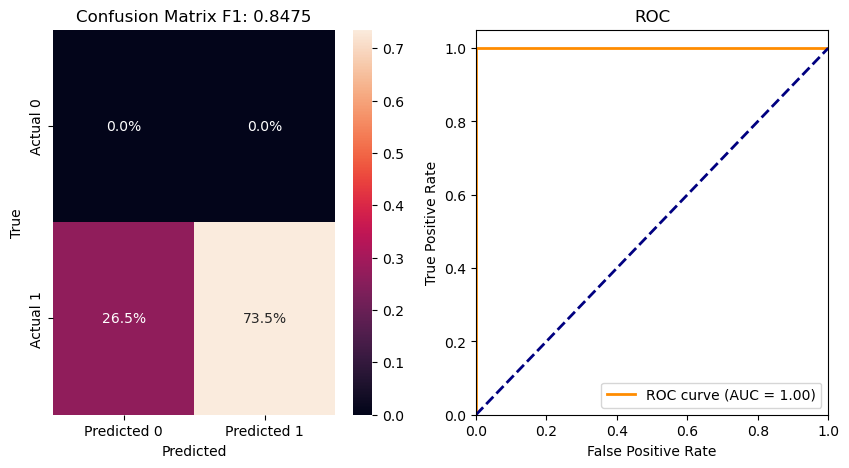

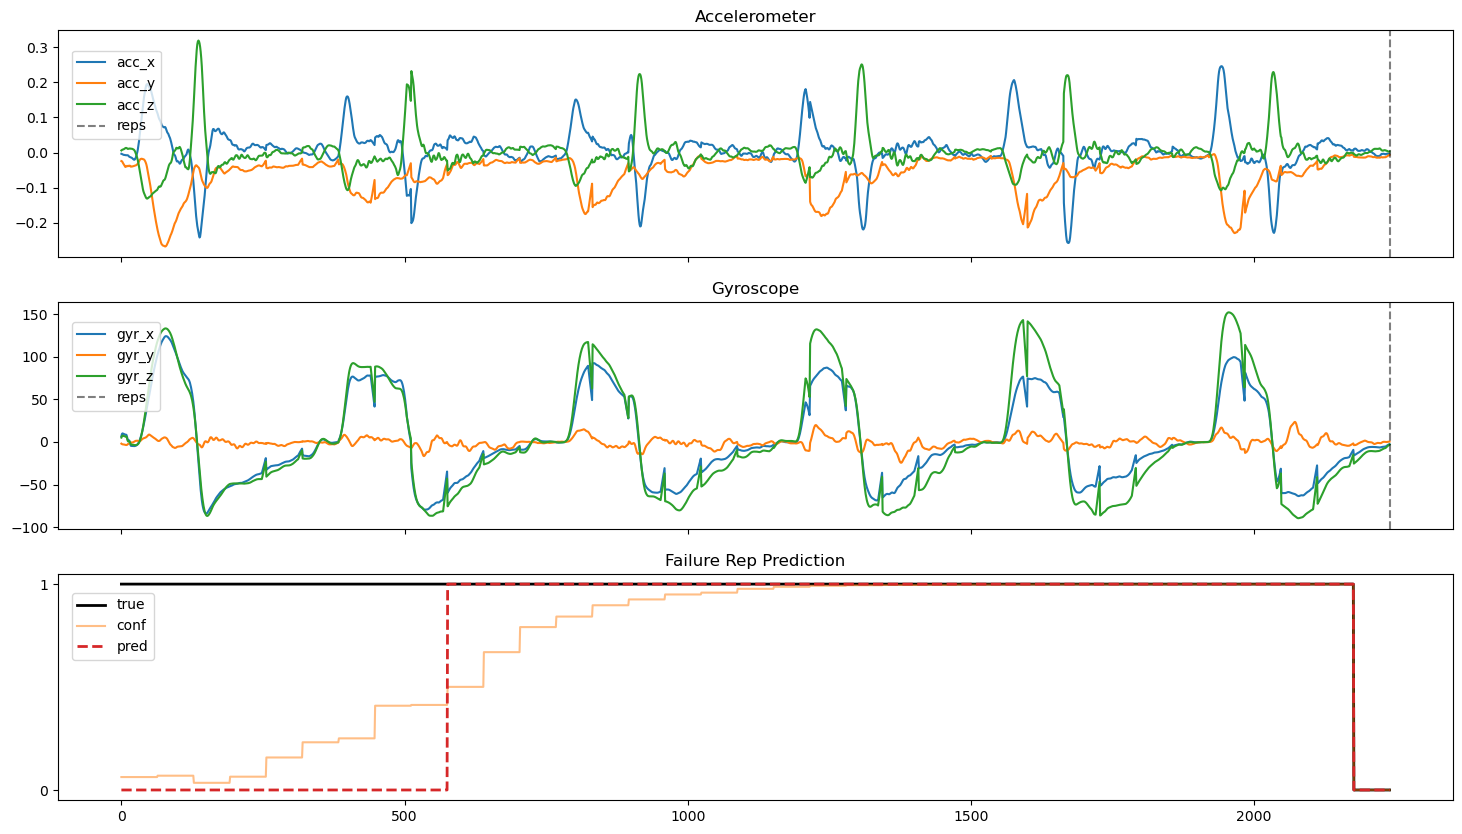

In [ ]:
session_id = 72

session = df[df['session_id'] == session_id]
session_dataset = IMUDatasetSimple(session, winsize, LSTM_stride, transform=None, aug=False)
print("Data:", session_dataset.X[:, 1984:2240])
print("Shape:", session_dataset.X[:, :2240].shape)
print(session_dataset.X.dtype)
print(session_dataset.X.numpy().dtype)
interval = LSTM_stride
ypreds, ys, confs, precision, recall, f1, accuracy, cm = evaluate_real_time(session_id, interval=LSTM_stride)
print("Confs:", confs[:32])

tn, fp, fn, tp = cm.flatten()
total = tn + fp + fn + tp

labels = np.array([
    [f"{tn:.1%}", f"{fp:.1%}"],
    [f"{fn:.1%}", f"{tp:.1%}"]
])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}")

ypreds = torch.cat([
    torch.repeat_interleave(ypreds, interval),
    torch.zeros(session.shape[0] - (len(session_dataset) * interval))
])
ys = torch.cat([
    torch.repeat_interleave(ys, interval),
    torch.zeros(session.shape[0] - (len(session_dataset) * interval))
])
confs = torch.cat([
    torch.repeat_interleave(confs, interval),
    torch.zeros(session.shape[0] - (len(session_dataset) * interval))
])

fig, axes = plt.subplots(1,2,figsize=(10, 5))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title(f'Confusion Matrix F1: {f1:.4f}')

fpr, tpr, thresholds = roc_curve(ys, confs)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal (random classifier)

# Formatting
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC')
axes[1].legend(loc="lower right")

fig, axes = plt.subplots(3,1, sharex=True, figsize=(18,10))
axes[0].set_title('Accelerometer')
axes[0].plot(session['acc_x'].values, label='acc_x')
axes[0].plot(session['acc_y'].values, label='acc_y')
axes[0].plot(session['acc_z'].values, label='acc_z')

axes[1].set_title('Gyroscope')
axes[1].plot(session['gyr_x'].values, label='gyr_x')
axes[1].plot(session['gyr_y'].values, label='gyr_y')
axes[1].plot(session['gyr_z'].values, label='gyr_z')

axes[2].set_title('Failure Rep Prediction')
axes[2].plot(ys, label='true', linewidth=2, color='black')
axes[2].plot(confs, label='conf', alpha=0.5, color='tab:orange')
axes[2].plot(ypreds, label='pred', linestyle='--', linewidth=2, color='tab:red')
axes[2].set_yticks([0,1])
axes[2].set_yticklabels(['0','1'])

for end_rep_marker in np.where(np.diff(session.rir.values) < 0)[0]:
    axes[0].axvline(end_rep_marker, color='black', linestyle='--', alpha=0.5)
    axes[1].axvline(end_rep_marker, color='black', linestyle='--', alpha=0.5)
axes[0].axvline(len(session), color='black', linestyle='--', alpha=0.5, label='reps')
axes[1].axvline(len(session), color='black', linestyle='--', alpha=0.5, label='reps')

# axes[3].plot(session['rir'].values, label='rir')
axes[0].legend(loc=(.01, .52))
axes[1].legend(loc=(.01, .52))
axes[2].legend(loc=(.01, .62))
# axes[3].legend(loc=(1.01, 0))